<a href="https://colab.research.google.com/github/madnanshinwari/DeepLearning-work/blob/main/lungs_cancer_classification_using_MobileNetV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [ ]:
!kaggle datasets download -d muhammadhamzamaher/lungs-cancer-dataset

Dataset URL: https://www.kaggle.com/datasets/muhammadhamzamaher/lungs-cancer-dataset
License(s): CC0-1.0
lungs-cancer-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/lungs-cancer-dataset.zip')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam


In [ ]:
train_path = '/content/Training'
test_path = '/content/Testing'
val_path = '/content/Validation'

### Data Augmentation and Preprocessing

In [ ]:
train_datagen = ImageDataGenerator(
    rescale = 1.0/255,
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest'
)
val_test_datagen = ImageDataGenerator(rescale = 1.0/255.0)

### Data Generator

In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size = (224, 224),
    batch_size = 32,
    class_mode = 'categorical'
)
Validation_generator = val_test_datagen.flow_from_directory(
    val_path,
    target_size = (224, 224),
    batch_size = 32,
    class_mode = 'categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    test_path,
    target_size = (224, 224),
    batch_size = 32,
    class_mode = 'categorical'
)

Found 12007 images belonging to 3 classes.
Found 1500 images belonging to 3 classes.
Found 1500 images belonging to 3 classes.


### Simple CNN Model Definition


In [ ]:
simple_cnn = Sequential([
    Conv2D(32, (3, 3), activation = 'relu', input_shape = (224,224,3)),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Flatten(),
    Dense(512, activation = 'relu'),
    Dropout(0.5),
    Dense(3,activation='softmax') # output layer


])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
simple_cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'] )
simple_cnn.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 512)                 │      44,302,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 3)                   │           1,539 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 44,397,635 (169.36 MB)

 Trainable params: 44,397,635 (169.36 MB)

 Non-trainable params: 0 (0.00 B)

### Train simple CNN Model

In [ ]:
simple_cnn_history = simple_cnn.fit(
    train_generator,
    epochs = 10,
    validation_data = Validation_generator
)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


376/376 ━━━━━━━━━━━━━━━━━━━━ 179s 458ms/step - accuracy: 0.7181 - loss: 0.7664 - val_accuracy: 0.8513 - val_loss: 0.3525
Epoch 2/10
376/376 ━━━━━━━━━━━━━━━━━━━━ 201s 460ms/step - accuracy: 0.8951 - loss: 0.2641 - val_accuracy: 0.9060 - val_loss: 0.2112
Epoch 3/10
376/376 ━━━━━━━━━━━━━━━━━━━━ 173s 453ms/step - accuracy: 0.9075 - loss: 0.2259 - val_accuracy: 0.9100 - val_loss: 0.2078
Epoch 4/10
376/376 ━━━━━━━━━━━━━━━━━━━━ 205s 458ms/step - accuracy: 0.9135 - loss: 0.2184 - val_accuracy: 0.9373 - val_loss: 0.1629
Epoch 5/10
376/376 ━━━━━━━━━━━━━━━━━━━━ 173s 453ms/step - accuracy: 0.9150 - loss: 0.2101 - val_accuracy: 0.9427 - val_loss: 0.1507
Epoch 6/10
376/376 ━━━━━━━━━━━━━━━━━━━━ 180s 472ms/step - accuracy: 0.9178 - loss: 0.2041 - val_accuracy: 0.9440 - val_loss: 0.1572
Epoch 7/10
376/376 ━━━━━━━━━━━━━━━━━━━━ 173s 454ms/step - accuracy: 0.9158 - loss: 0.2051 - val_accuracy: 0.9387 - val_loss: 0.1611
Epoch 8/10
376/376 ━━━━━━━━━━━━━━━━━━━━ 177s 461ms/step - accuracy: 0.9211 - loss: 0.20

### Evaluate Simple CNN model

In [ ]:
simple_cnn_eval = simple_cnn.evaluate(test_generator)
print(f'Simple CNN Test Accuarcy: {simple_cnn_eval[1] * 100:.2f}%')

47/47 ━━━━━━━━━━━━━━━━━━━━ 6s 132ms/step - accuracy: 0.9420 - loss: 0.1355
Simple CNN Test Accuarcy: 94.47%


### MobileNetV2 Model Definition

In [ ]:
from  tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import BatchNormalization
base_model_mobilenetv2 = MobileNetV2(weights= 'imagenet', include_top=False, input_shape=(224, 224, 3))

x = base_model_mobilenetv2.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu', kernel_regularizer=l2(0.01))(x)

x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predication = Dense(3, activation ='softmax')(x)


model_mobilenetv2 = Model(inputs = base_model_mobilenetv2.input, outputs = predication)
model_mobilenetv2.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
model_mobilenetv2.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer_8[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 3,576,899 (13.64 MB)

 Trainable params: 3,540,739 (13.51 MB)

 Non-trainable params: 36,160 (141.25 KB)

### Train MobileNetV2 Model

In [ ]:
mobilenetv2_history = model_mobilenetv2.fit(
    train_generator,
    validation_data=Validation_generator,
    epochs=5
)


Epoch 1/5
376/376 ━━━━━━━━━━━━━━━━━━━━ 249s 532ms/step - accuracy: 0.8663 - loss: 10.8719 - val_accuracy: 0.5987 - val_loss: 13.7043
Epoch 2/5
376/376 ━━━━━━━━━━━━━━━━━━━━ 221s 467ms/step - accuracy: 0.9676 - loss: 7.0265 - val_accuracy: 0.7773 - val_loss: 6.6397
Epoch 3/5
376/376 ━━━━━━━━━━━━━━━━━━━━ 201s 465ms/step - accuracy: 0.9782 - loss: 4.4872 - val_accuracy: 0.9013 - val_loss: 3.6680
Epoch 4/5
376/376 ━━━━━━━━━━━━━━━━━━━━ 177s 463ms/step - accuracy: 0.9853 - loss: 2.8069 - val_accuracy: 0.9787 - val_loss: 2.0241
Epoch 5/5
376/376 ━━━━━━━━━━━━━━━━━━━━ 178s 465ms/step - accuracy: 0.9860 - loss: 1.7548 - val_accuracy: 0.9533 - val_loss: 1.4696


### Evaluate MobileNetV2 Model

In [ ]:
mobilenetv2_eval =  model_mobilenetv2.evaluate(test_generator)
print(f'MobileNetV2 Test Accuracy: {mobilenetv2_eval[1] * 100:.2f}%')

47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 110ms/step - accuracy: 0.9661 - loss: 1.3647
MobileNetV2 Test Accuracy: 95.93%


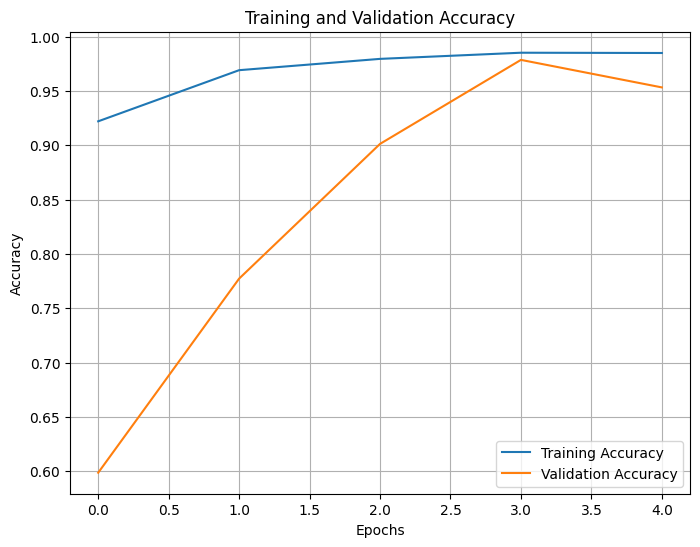

In [48]:
import matplotlib.pyplot as plt

# Plot the training and validation accuracy
def plot_accuracy(history):
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()


# Call the functions with your history object
plot_accuracy(mobilenetv2_history)



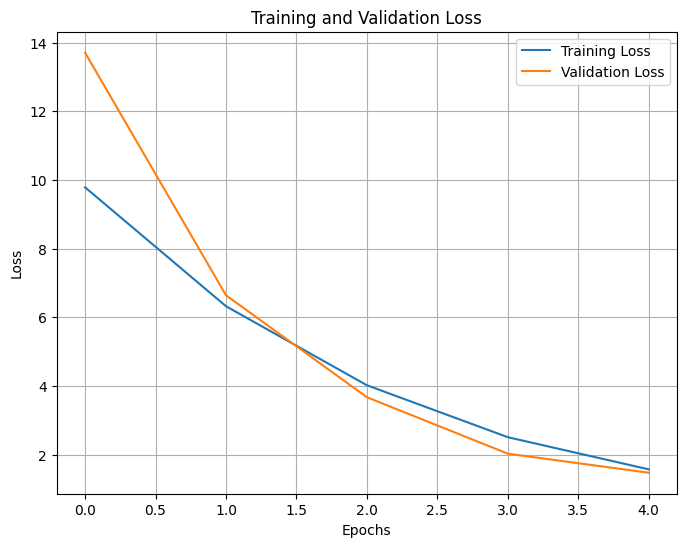

In [49]:

# Plot the training and validation loss
def plot_loss(history):
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
plot_loss(mobilenetv2_history)

In [54]:
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input


def preprocess_image(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array


def predict_image(model, img_path, class_names):
    img_array = preprocess_image(img_path)
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)
    return class_names[predicted_class[0]], predictions[0]


img_path = '/content/Validation/Lung_squamous cell_carcinoma/lungscc2163.jpeg'
class_names = ['Lung_adenocarcinoma', 'Lung_benign_tissue', 'Lung_squamous_cell_c']

predicted_class, probabilities = predict_image(model_mobilenetv2, img_path, class_names)

print(f"Predicted class: {predicted_class}")
print(f"Class probabilities: {probabilities}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Predicted class: Lung_squamous_cell_c
Class probabilities: [1.4113959e-05 3.8323060e-06 9.9998200e-01]
